## 卷积神经网络

In [26]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

- 处理数据

In [27]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


- 数据处理成`[batch_size, image_size, image_size, channels]`
- 标签处理成`one hot`

In [28]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [29]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

- 两层卷积层，其中卷积层步长为2
- 特征映射的数目均为64
- 准确率 88%

In [30]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    shape = hidden.get_shape().as_list()
    print(shape)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    print(shape)
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[16, 14, 14, 16]
[16, 7, 7, 16]
[10000, 14, 14, 16]
[10000, 7, 7, 16]
[10000, 14, 14, 16]
[10000, 7, 7, 16]


In [31]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.809623
Minibatch accuracy: 6.2%
Validation accuracy: 8.2%
Minibatch loss at step 50: 1.407817
Minibatch accuracy: 56.2%
Validation accuracy: 49.5%
Minibatch loss at step 100: 1.579872
Minibatch accuracy: 56.2%
Validation accuracy: 64.3%
Minibatch loss at step 150: 0.726914
Minibatch accuracy: 93.8%
Validation accuracy: 76.3%
Minibatch loss at step 200: 0.895602
Minibatch accuracy: 75.0%
Validation accuracy: 75.8%
Minibatch loss at step 250: 0.702833
Minibatch accuracy: 81.2%
Validation accuracy: 80.0%
Minibatch loss at step 300: 0.887109
Minibatch accuracy: 75.0%
Validation accuracy: 77.8%
Minibatch loss at step 350: 0.459326
Minibatch accuracy: 87.5%
Validation accuracy: 80.1%
Minibatch loss at step 400: 0.649843
Minibatch accuracy: 75.0%
Validation accuracy: 81.1%
Minibatch loss at step 450: 0.944354
Minibatch accuracy: 75.0%
Validation accuracy: 80.4%
Minibatch loss at step 500: 0.571693
Minibatch accuracy: 87.5%
Validation accuracy: 81.3%
Min

- 直接改成加上池化层效果还是88%左右
- 所以改成了特征映射分别为`32`，`64`，全连接隐藏节点`256`个；隐藏节点`1024`个效果非常差。
- 准确率： 90%

In [32]:
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 256

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(tf.nn.max_pool(conv + layer1_biases, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME'))
    shape = hidden.get_shape().as_list()
    print(shape)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(tf.nn.max_pool(conv + layer2_biases, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME'))
    shape = hidden.get_shape().as_list()
    print(shape)
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[16, 14, 14, 32]
[16, 7, 7, 64]
[10000, 14, 14, 32]
[10000, 7, 7, 64]
[10000, 14, 14, 32]
[10000, 7, 7, 64]


In [33]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 9.630028
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.061450
Minibatch accuracy: 62.5%
Validation accuracy: 60.5%
Minibatch loss at step 100: 1.853973
Minibatch accuracy: 50.0%
Validation accuracy: 66.9%
Minibatch loss at step 150: 0.642839
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 200: 0.505073
Minibatch accuracy: 87.5%
Validation accuracy: 79.9%
Minibatch loss at step 250: 0.570606
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 300: 0.516718
Minibatch accuracy: 81.2%
Validation accuracy: 80.9%
Minibatch loss at step 350: 0.508198
Minibatch accuracy: 75.0%
Validation accuracy: 80.8%
Minibatch loss at step 400: 0.572958
Minibatch accuracy: 75.0%
Validation accuracy: 82.2%
Minibatch loss at step 450: 0.759367
Minibatch accuracy: 75.0%
Validation accuracy: 82.8%
Minibatch loss at step 500: 0.613860
Minibatch accuracy: 75.0%
Validation accuracy: 82.5%
Mi

- 类似LeNet5，然而并不是，没有Dropout，没有正则化
- 标准LeNet5
  ![标准LeNet5](http://7xsbsy.com1.z0.glb.clouddn.com/NNML__5__8.png)
- 一个简单的LeNet
  ![一个简单的LeNet](http://deeplearning.net/tutorial/_images/mylenet.png)
- 准确率： 94%

In [33]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
constant_bias = 0.1

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(constant_bias, shape=[depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(constant_bias, shape=[depth]))
  size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
  layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(constant_bias, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(constant_bias, shape=[num_labels]))
  
  # Model.
  def model(data):
    # C1 input 28 x 28
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    # S2 input 24 x 24
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # C3 input 12 x 12
    conv3 = tf.nn.conv2d(pool2, layer2_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    # S4 input 8 x 8
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    # F6 input 4 x 4
    shape = pool4.get_shape().as_list()
    reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 2.293002
Minibatch accuracy: 12.5%
Validation accuracy: 11.5%
Minibatch loss at step 50: 1.665669
Minibatch accuracy: 37.5%
Validation accuracy: 34.8%
Minibatch loss at step 100: 1.755066
Minibatch accuracy: 31.2%
Validation accuracy: 51.7%
Minibatch loss at step 150: 0.798242
Minibatch accuracy: 87.5%
Validation accuracy: 71.0%
Minibatch loss at step 200: 1.024715
Minibatch accuracy: 62.5%
Validation accuracy: 72.5%
Minibatch loss at step 250: 0.700513
Minibatch accuracy: 81.2%
Validation accuracy: 77.3%
Minibatch loss at step 300: 0.947052
Minibatch accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 350: 0.505861
Minibatch accuracy: 81.2%
Validation accuracy: 77.2%
Minibatch loss at step 400: 0.859947
Minibatch accuracy: 75.0%
Validation accuracy: 78.3%
Minibatch loss at step 450: 1.171692
Minibatch accuracy: 68.8%
Validation accuracy: 75.2%
Minibatch loss at step 500: 0.785399
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
M

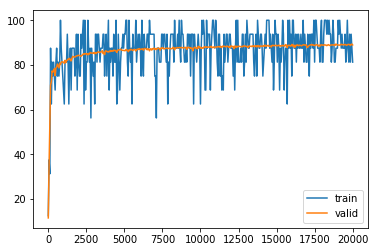

In [38]:
import matplotlib.pyplot as plt
x1 = []
y1 = []
y2 = []
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      acc1 = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: %.1f%%' % acc1)
      acc2 = accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: %.1f%%' % acc2)
      x1.append(step)
      y1.append(acc1)
      y2.append(acc2)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  plt.plot(x1, y1, label='train')
  plt.plot(x1, y2, label='valid')
  plt.legend()
  plt.show()